In [8]:
"""
Package Import
"""
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import quantstats as qs
# import gurobipy as gp
import warnings
# import argparse

"""
Project Setup
"""
warnings.simplefilter(action="ignore", category=FutureWarning)

assets = [
    "SPY",
    "XLB",
    "XLC",
    "XLE",
    "XLF",
    "XLI",
    "XLK",
    "XLP",
    "XLRE",
    "XLU",
    "XLV",
    "XLY",
]

# Initialize Bdf and df
Bdf = pd.DataFrame()
for asset in assets:
    raw = yf.download(asset, start="2012-01-01", end="2024-04-01", auto_adjust = False)
    Bdf[asset] = raw['Adj Close']

df = Bdf.loc["2019-01-01":"2024-04-01"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
data_returns = Bdf.pct_change().ffill().fillna(0)

In [132]:
from numpy import ndarray, float64
from typing import List
from pandas import Series

def sharpe_ratio(returns: ndarray | List | Series, trading_periods: int) -> float64:
    """
    Calculate the Sharpe Ratio from a sequence of returns.
    
    Parameters:
        returns (array-like): Sequence of returns.
        trading_periods (int): Number of trading periods in a year.
        
    Returns:
        float64: Sharpe Ratio value.
    """
    returns = np.asarray(returns)
    std = returns.std()
    mean = returns.mean()
    sr = mean / std if std != 0 else np.inf
    return sr * np.sqrt(trading_periods)

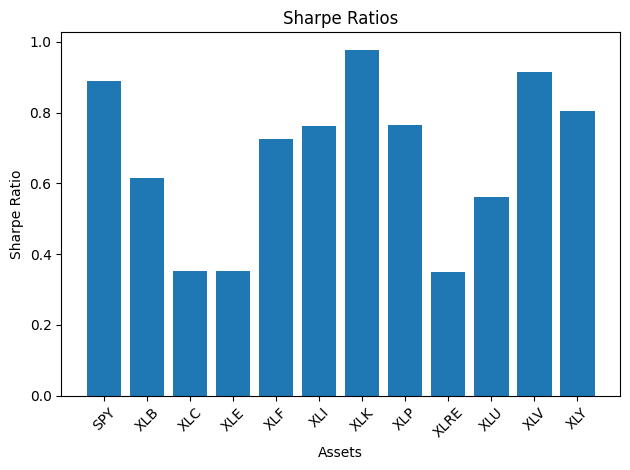

In [ ]:
rolling_returns = {col: sharpe_ratio(data_returns[col], 252) for col in data_returns.columns}

plt.bar(rolling_returns.keys(), rolling_returns.values())
plt.title("Sharpe Ratios")
plt.xlabel("Assets")
plt.ylabel("Sharpe Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Equity Curve'}, xlabel='Date'>

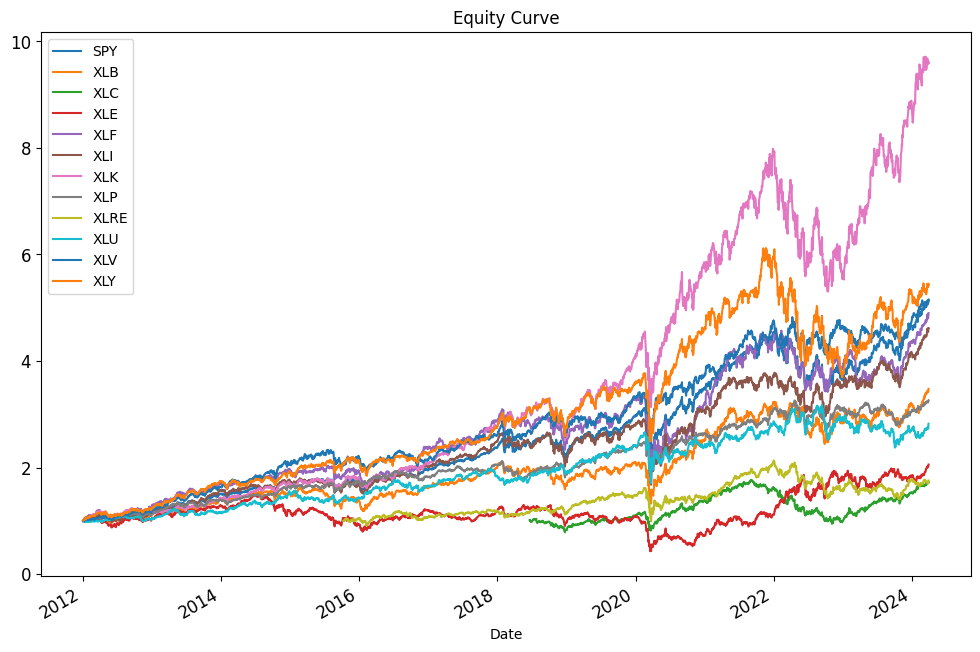

In [19]:
(data_returns + 1).cumprod().plot(figsize=(12, 8), title="Equity Curve", fontsize=12)

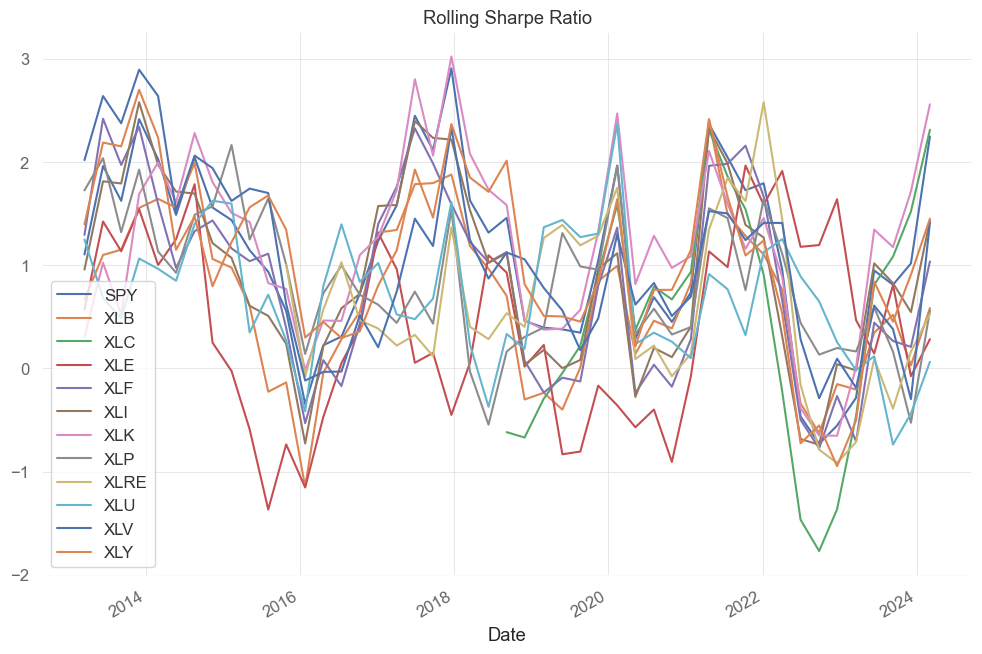

In [106]:
data_returns.rolling(252, step=60).apply(sharpe_ratio, args=(252,)).plot(figsize=(12, 8), title="Rolling Sharpe Ratio", fontsize=12)
plt.show()

In [ ]:
def cum_returns(returns: ndarray | List | Series) -> float64:
    """
    Calculate the cumulative returns from a sequence of returns.
    
    Parameters:
        returns (array-like): Sequence of returns.
        
    Returns:
        float64: Cumulative return value.
    """
    returns = np.asarray(returns)
    return np.prod(returns + 1) - 1

In [142]:
"""
Package Import
"""
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import quantstats as qs
from quantstats import stats, reports
import gurobipy as gp
import warnings
import argparse

"""
Project Setup
"""
warnings.simplefilter(action="ignore", category=FutureWarning)

assets = [
    "SPY",
    "XLB",
    "XLC",
    "XLE",
    "XLF",
    "XLI",
    "XLK",
    "XLP",
    "XLRE",
    "XLU",
    "XLV",
    "XLY",
]

# Initialize Bdf and df
Bdf = pd.DataFrame()
for asset in assets:
    raw = yf.download(asset, start="2012-01-01", end="2024-04-01", auto_adjust = False)
    Bdf[asset] = raw['Adj Close']

df = Bdf.loc["2019-01-01":"2024-04-01"]

"""
Strategy Creation

Create your own strategy, you can add parameter but please remain "price" and "exclude" unchanged
"""


class MyPortfolio:
    """
    NOTE: You can modify the initialization function
    """

    def __init__(self, price, exclude, lookback=120, step=1, gamma=0):
        self.price = price
        self.returns = price.pct_change().fillna(0)
        self.exclude = exclude
        self.lookback = lookback
        self.step = step
        self.gamma = gamma

    def calculate_weights(self):
        # Get the assets by excluding the specified column
        assets = self.price.columns[self.price.columns != self.exclude]

        # Calculate the portfolio weights
        self.portfolio_weights = pd.DataFrame(
            index=self.price.index, columns=self.price.columns
        )

        """
        TODO: Complete Task 4 Below
        """
        rolling_returns = self.returns.rolling(self.lookback, step=self.step).apply(cum_returns).shift(1)
        pos_returns = rolling_returns.where(rolling_returns > 0, 0) ** 2
        self.portfolio_weights[assets] = pos_returns[assets].div(
            pos_returns[assets].sum(axis=1), axis=0
        )
        self.portfolio_weights[self.exclude] = 0
        """
        TODO: Complete Task 4 Above
        """

        self.portfolio_weights.ffill(inplace=True)
        self.portfolio_weights.fillna(0, inplace=True)

    def calculate_portfolio_returns(self):
        # Ensure weights are calculated
        if not hasattr(self, "portfolio_weights"):
            self.calculate_weights()

        # Calculate the portfolio returns
        self.portfolio_returns = self.returns.copy()
        assets = self.price.columns[self.price.columns != self.exclude]
        self.portfolio_returns["Portfolio"] = (
            self.portfolio_returns[assets]
            .mul(self.portfolio_weights[assets])
            .sum(axis=1)
        )

    def get_results(self):
        # Ensure portfolio returns are calculated
        if not hasattr(self, "portfolio_returns"):
            self.calculate_portfolio_returns()

        return self.portfolio_weights, self.portfolio_returns


"""
Assignment Judge

The following functions will help check your solution.
"""


class AssignmentJudge:
    def __init__(self):
        self.mp = MyPortfolio(df, "SPY").get_results()
        self.Bmp = MyPortfolio(Bdf, "SPY").get_results()

    def plot_performance(self, price, strategy):
        # Plot cumulative returns
        _, ax = plt.subplots()
        returns = price.pct_change().fillna(0)
        (1 + returns["SPY"]).cumprod().plot(ax=ax, label="SPY")
        (1 + strategy[1]["Portfolio"]).cumprod().plot(ax=ax, label=f"MyPortfolio")

        ax.set_title("Cumulative Returns")
        ax.set_xlabel("Date")
        ax.set_ylabel("Cumulative Returns")
        ax.legend()
        plt.show()
        return None

    def plot_allocation(self, df_weights):
        df_weights = df_weights.fillna(0).ffill()

        # long only
        df_weights[df_weights < 0] = 0

        # Plotting
        _, ax = plt.subplots()
        df_weights.plot.area(ax=ax)
        ax.set_xlabel("Date")
        ax.set_ylabel("Allocation")
        ax.set_title("Asset Allocation Over Time")
        plt.show()
        return None

    def report_metrics(self, price, strategy, show=False):
        df_bl = pd.DataFrame()
        returns = price.pct_change().fillna(0)
        df_bl["SPY"] = returns["SPY"]
        df_bl["MP"] = pd.to_numeric(strategy[1]["Portfolio"], errors="coerce")
        sharpe_ratio = stats.sharpe(df_bl)

        if show == True:
            reports.metrics(df_bl, mode="full", display=show)

        return sharpe_ratio

    def cumulative_product(self, dataframe):
        (1 + dataframe.pct_change().fillna(0)).cumprod().plot()

    def check_sharp_ratio_greater_than_one(self):
        if not self.check_portfolio_position(self.mp[0]):
            return 0
        if self.report_metrics(df, self.mp)[1] > 1:
            print("Problem 4.1 Success - Get 15 points")
            return 15
        else:
            print("Problem 4.1 Fail")
        return 0

    def check_sharp_ratio_greater_than_spy(self):
        if not self.check_portfolio_position(self.mp[0]):
            return 0
        if (
            self.report_metrics(Bdf, self.Bmp)[1]
            > self.report_metrics(Bdf, self.Bmp)[0]
        ):
            print("Problem 4.2 Success - Get 15 points")
            return 15
        else:
            print("Problem 4.2 Fail")
        return 0

    def check_portfolio_position(self, portfolio_weights):
        if (portfolio_weights.sum(axis=1) <= 1.01).all():
            return True
        print("Portfolio Position Exceeds 1. No Leverage.")
        return False

    def check_all_answer(self):
        score = 0
        score += self.check_sharp_ratio_greater_than_one()
        score += self.check_sharp_ratio_greater_than_spy()
        return score


judge = AssignmentJudge()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [143]:
# lookbacks = [10, 20, 60, 120, 252]
# steps = [1, 5, 10, 20, 60]
# for lookback in lookbacks:
#     for step in steps:
#         judge.mp = MyPortfolio(df, "SPY", lookback=lookback, step=step).get_results()
#         judge.Bmp = MyPortfolio(Bdf, "SPY", lookback=lookback, step=step).get_results()
#         print(f"Lookback: {lookback}, Step: {step}")
#         print("Sharpe Ratio:", judge.report_metrics(df, judge.mp)[1])
#         print("Sharpe Ratio (Benchmark):", judge.report_metrics(Bdf, judge.Bmp)[1])
#         print("-" * 50)

judge.report_metrics(df, judge.mp)

SPY    0.865379
MP     1.036551
dtype: float64

In [144]:
judge.report_metrics(Bdf, judge.Bmp)

SPY    0.889802
MP     0.922050
dtype: float64